# Object Detection

In [1]:
%%bash
git clone --depth 1 https://github.com/tensorflow/models

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install . --user --quiet
pip install --user --quiet protobuf==3.20
pip install --user --quiet numpy --force-reinstall

fatal: destination path 'models' already exists and is not an empty directory.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.55.0 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
google-cloud-recommendations-ai 0.2.0 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.8.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorb

In [2]:
import os
import io
import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Load Data

In [3]:
CSV_PATH = "../dataset_import_files/salads.csv"
!head $CSV_PATH

gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Baked Goods,0.005743,0.084985,,,0.567511,0.735736,,
gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Salad,0.402759,0.310473,,,1.000000,0.982695,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.000000,0.000000,,,0.054865,0.480665,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.041131,0.401678,,,0.318230,0.785916,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.116263,0.065161,,,0.451528,0.286489,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.557359,0.411551,,,0.988760,0.731613,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.562206,0.059401,,,0.876467,0.260982,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.567861,0.000161,,,0.699543,0.077502,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.916052,0.085569,,,1.0

In [4]:
df = pd.read_csv(CSV_PATH)
PATHES = df.iloc[:, 0].unique()
CLASSES = df.iloc[:, 1].unique()

In [5]:
img_id_lookup = tf.keras.layers.StringLookup(vocabulary=PATHES)
class_lookup = tf.keras.layers.StringLookup(vocabulary=CLASSES)

2022-10-13 13:02:21.161152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 13:02:21.174139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 13:02:21.175989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 13:02:21.178286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Read CSV and create dataset

In [6]:
def parse_csv(row):
    row = tf.strings.split(row, ",")
    path = row[0]
    label = row[1]
    one_hot_label = class_lookup(label)
    sbox = tf.gather(row, [3, 2, 7, 6])
    bbox = tf.strings.to_number(sbox)
    return path, one_hot_label, bbox

data = tf.data.TextLineDataset(CSV_PATH).map(
    parse_csv
)

Group multipule rows by using image path as the key.

In [7]:
WINDOW_SIZE = 50
SEED = 3

data = data.group_by_window(
    key_func=lambda path,label,bbox: img_id_lookup(path),
    reduce_func=lambda _, window: window.batch(WINDOW_SIZE),
    window_size=WINDOW_SIZE).shuffle(len(PATHES), seed=SEED)

Define image loader and decoder.

In [8]:
def decode_jpg(path, label, bbox):
    img = tf.io.read_file(path[0])
    img = tf.io.decode_jpeg(img, channels=3)
    return path[0], img, label, bbox

data = data.map(decode_jpg)

Split data into train and test.

In [9]:
TRAIN_SIZE = int(len(PATHES) * 0.8)

train_data = data.take(TRAIN_SIZE)
test_data = data.skip(TRAIN_SIZE)

In [10]:
for path, img, label, bbox in train_data.take(1):
    print(f'path: {path}')
    print(f'img: {img}')
    print(f'label: {label}')
    print(f'bbox: {bbox}')

path: b'gs://cloud-ml-data/img/openimage/5/4009/4589206559_5d6f49fd94_o.jpg'
img: [[[ 17  31  34]
  [ 16  30  31]
  [ 15  29  29]
  ...
  [109  74  42]
  [108  74  39]
  [107  73  38]]

 [[ 16  30  33]
  [ 16  30  31]
  [ 15  29  29]
  ...
  [109  74  44]
  [109  74  42]
  [108  74  39]]

 [[ 16  30  33]
  [ 15  29  30]
  [ 15  29  29]
  ...
  [109  74  46]
  [109  74  44]
  [110  75  43]]

 ...

 [[100  68  29]
  [ 94  62  24]
  [ 88  55  22]
  ...
  [125  94  74]
  [126  95  77]
  [127  95  80]]

 [[ 92  57  27]
  [ 84  55  21]
  [ 81  62  20]
  ...
  [122  96  73]
  [123  95  73]
  [126  95  74]]

 [[ 92  57  25]
  [ 84  56  19]
  [ 81  62  19]
  ...
  [122  96  73]
  [123  95  73]
  [126  95  74]]]
label: [1 3 4 4 4 4 4]
bbox: [[0.111368 0.106359 0.890294 0.843813]
 [0.152102 0.12629  0.843742 0.815577]
 [0.628436 0.229268 0.738167 0.35107 ]
 [0.202811 0.335568 0.288435 0.460138]
 [0.641736 0.414739 0.806333 0.490588]
 [0.241882 0.607961 0.342469 0.691561]
 [0.513716 0.691007 0.584

## Visualize Training Data

In [11]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index):

    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.4,
        line_thickness=20)

    plt.imshow(image_np_with_annotations)

In [12]:
category_index = {i:{'id':i, 'name': class_name} for i, class_name in enumerate(class_lookup.get_vocabulary()) if class_name != '[UNK]'}
category_index

{1: {'id': 1, 'name': 'Salad'},
 2: {'id': 2, 'name': 'Cheese'},
 3: {'id': 3, 'name': 'Seafood'},
 4: {'id': 4, 'name': 'Tomato'},
 5: {'id': 5, 'name': 'Baked Goods'}}

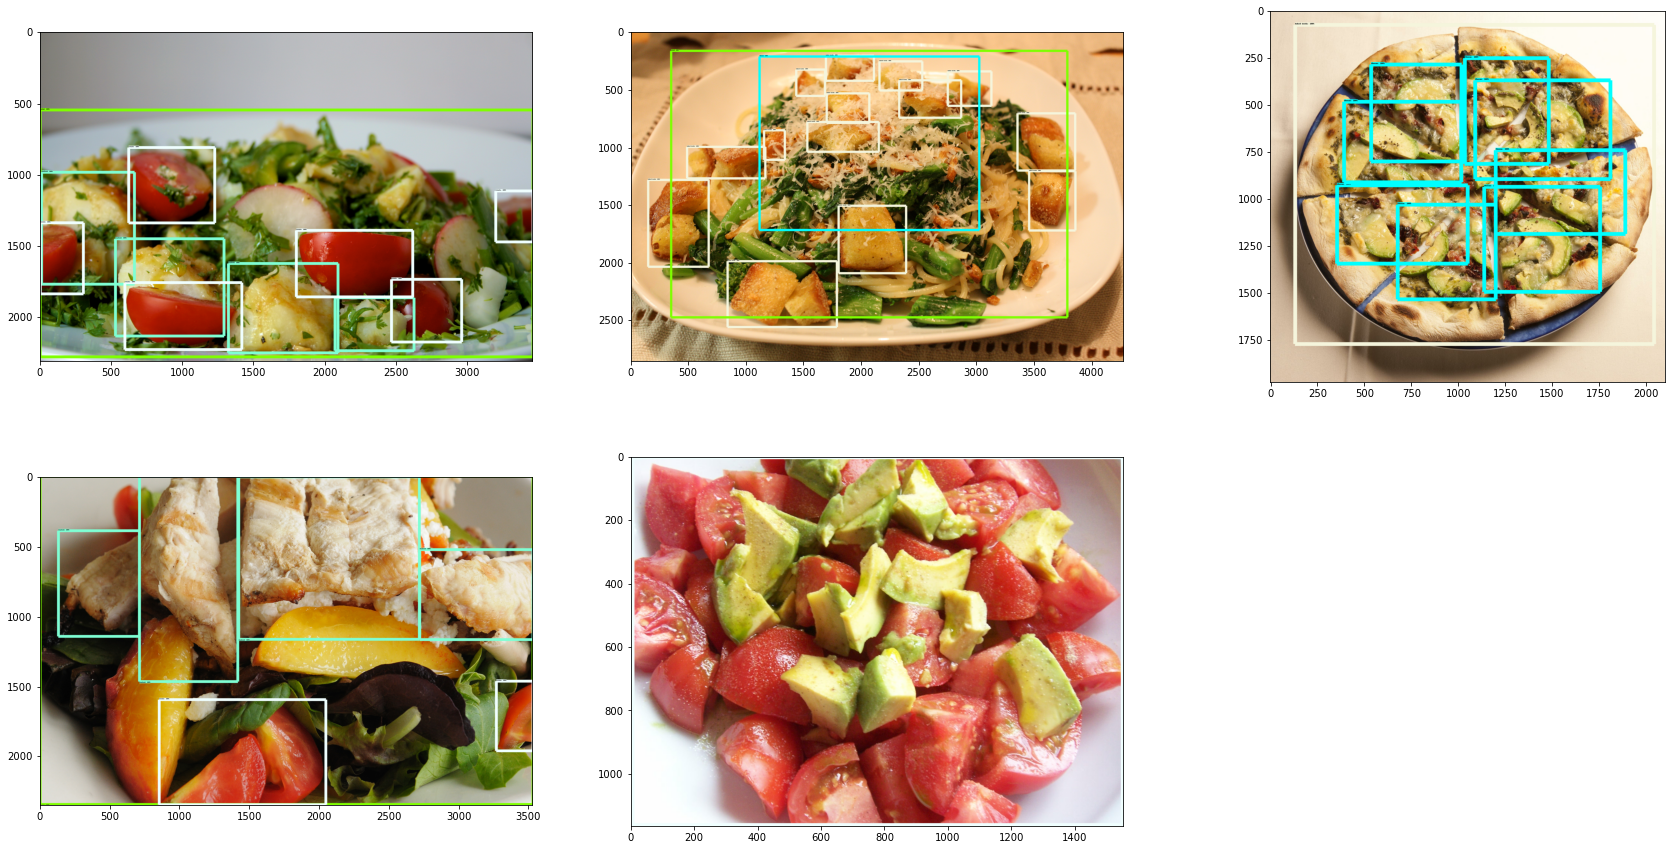

In [13]:
plt.figure(figsize=(30, 15))    
for idx, (path, img, label, bbox)  in enumerate(train_data.take(5)):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        img.numpy(),
        bbox.numpy(),
        label.numpy(),
        [1] * label.shape[0], # give boxes a score of 100%
        category_index,
  )
plt.show()

## Retrieve pretrained weights
In order to reuse pretrained weights, download the checkpoint file from public storage.

In [14]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-10-13 13:02:30--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.103.128, 2607:f8b0:4001:c2b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.103.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.10’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   488MB/s    in 0.5s    

2022-10-13 13:02:30 (488 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.10’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [15]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

Building model and restoring weights for fine-tuning...


Load pipeline config and build a detection model.
#
Since we are working off of a COCO architecture which predicts 90 class slots by default, we override the `num_classes` field here to be just 5 (for our new salad datasets).

In [16]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = len(CLASSES)

model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

Set up object-based checkpoint restore --- RetinaNet has two prediction `heads` --- one for classification, the other for box regression.  

We will restore the box regression head but initialize the classification head from scratch (we show the omission below by commenting out the line that we would add if we wanted to restore both heads)

In [17]:
fake_box_predictor = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)

ckpt = tf.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

Run model through a dummy image so that variables are created

In [18]:
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

2022-10-13 13:02:35.452711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


Weights restored!


Select variables in top layers to fine-tune.

In [19]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

## Transfer Learning

Define the training loop.

In [20]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):

    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    batch_size):

        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            prediction_dict = model.predict(image_tensors, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

Apply preprocessing for transfer learning

In [21]:
def _preprocess(path, img, label, bbox):
    label = tf.one_hot(label, len(CLASSES))

    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32)
    img = detection_model.preprocess(img)[0]
    img = tf.squeeze(img, axis=0)
    return path, img, label, bbox

train_data = train_data.map(_preprocess)

Iterate over training data and update the selected weights.

This will take *** minutes with a NVidia T4 GPU.

In [22]:
NUM_SAMPLES = TRAIN_SIZE
BATCH_SIZE = 1
EPOCHS = 20
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)

total_loss = []
for idx, (path, img, label, bbox) in enumerate(train_data.batch(BATCH_SIZE).repeat(EPOCHS)):
    progress_percent = (idx % NUM_SAMPLES) / NUM_SAMPLES * 100 

    total_loss.append(train_step_fn(img, bbox, label, BATCH_SIZE))

    if idx != 0:
        if idx % NUM_SAMPLES == 0:
            print('')
        else:
            print(f"epoch {idx // NUM_SAMPLES + 1:<2}/{EPOCHS}, loss: {np.mean(total_loss[idx-(idx % NUM_SAMPLES):idx]):.4f} [{'■' * (math.ceil(progress_percent) // 5): <20}] {math.ceil(progress_percent)}%", end='\r', flush=True)

print('')
print('Done fine-tuning!')

Start fine-tuning!
epoch 1 /20, loss: 0.9165 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 2 /20, loss: 0.7933 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 3 /20, loss: 0.7320 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 4 /20, loss: 0.7525 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 5 /20, loss: 0.7221 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 6 /20, loss: 0.6986 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 7 /20, loss: 0.6850 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 8 /20, loss: 0.6627 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 9 /20, loss: 0.6941 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 10/20, loss: 0.6204 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 11/20, loss: 0.6607 [■■■■■■■■■■■■■■■■■■■■] 100%


KeyboardInterrupt: 

## Detection
Let's try to detect bounding boxes over the test data, and check if the transfer learning went well.

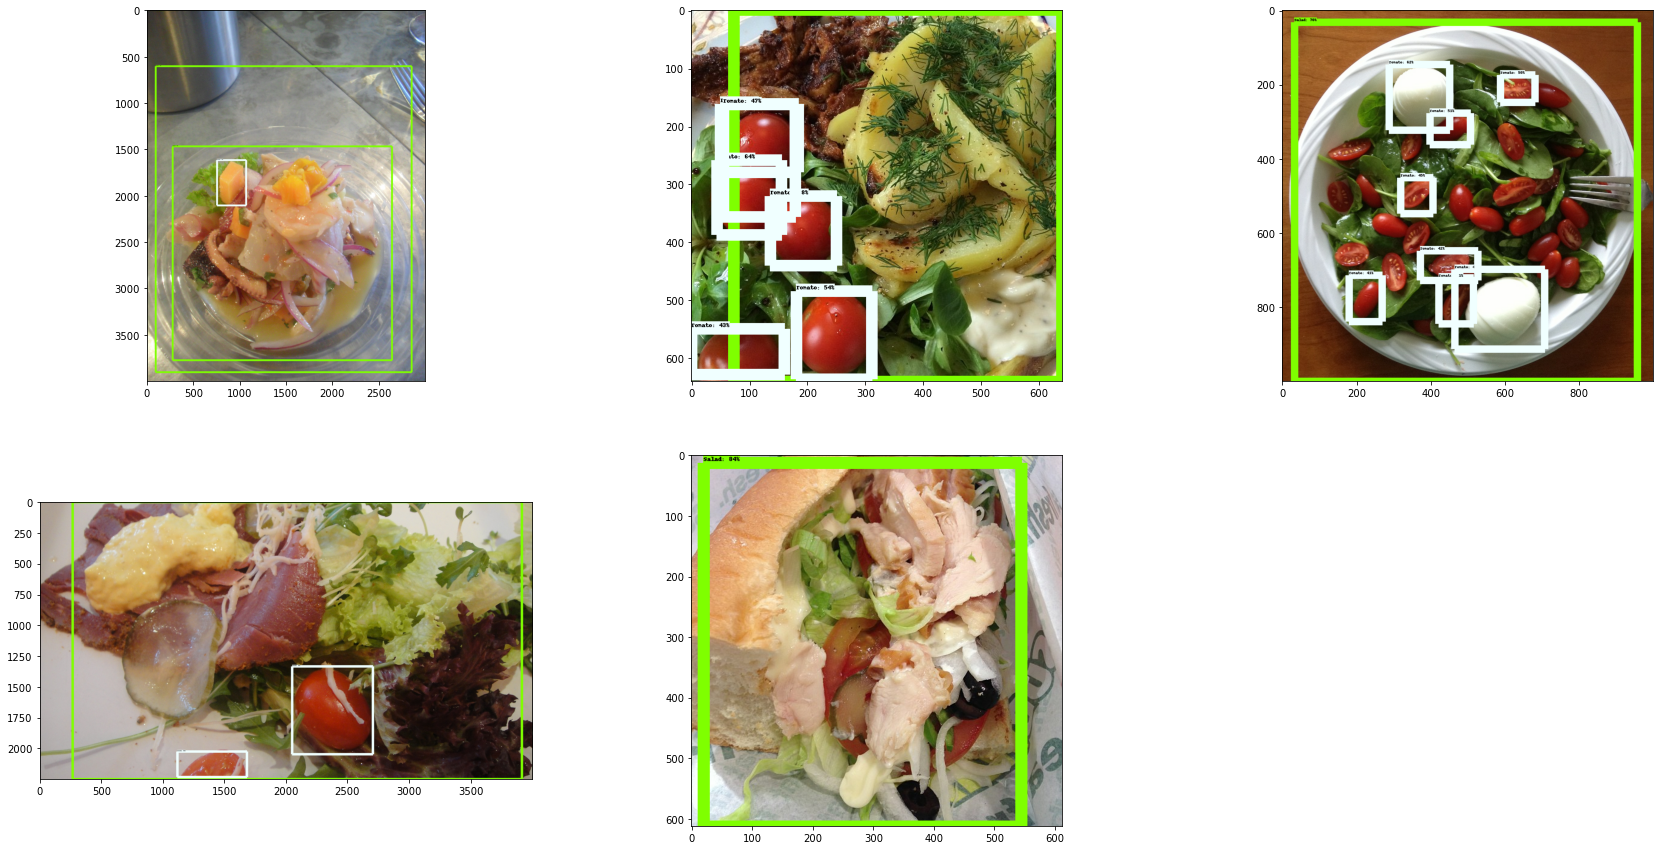

In [24]:
plt.figure(figsize=(30, 15))    
    
for idx, (path, img, label, bbox) in enumerate(test_data.take(5)):
    plt.subplot(2, 3, idx+1)

    _, preprocessed_img, _, _ = _preprocess(path, img, label, bbox)
    prediction_dict = detection_model.predict(tf.expand_dims(preprocessed_img, axis=0), shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    plot_detections(
        img.numpy(),
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32),
        detections['detection_scores'][0].numpy(),
        category_index)

plt.show()